In [20]:
import math

import cartopy.crs as ccrs

from teleconnections.tc_class import Teleconnection
from aqua.slurm import slurm

In [3]:
model1 = 'IFS'
exp1 = 'tco2559-ng5-cycle3'
source1 = 'lra-r100-monthly'

model2 = 'IFS'
exp2 = 'tco1279-orca025-cycle3'
source2 = '2D_monthly_native'

In [4]:
slurm.job()

2023-06-30 17:40:50 :: create_folder :: WARNING  -> Folder ./slurm already exists
2023-06-30 17:40:50 :: create_folder :: WARNING  -> Folder ./slurm/logs already exists
2023-06-30 17:40:50 :: create_folder :: WARNING  -> Folder ./slurm/output already exists


2023-06-30 17:40:54 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -A bb1153
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=10G
#SBATCH -t 02:30:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/work/bb1153/b382289/mambaforge/envs/teleconnections/bin/python -m distributed.cli.dask_worker tcp://136.172.124.2:35443 --nthreads 1 --memory-limit 9.31GiB --name dummy-name --nanny --death-timeout 60



In [5]:
telecname = 'NAO'
telec1 = Teleconnection(model=model1, exp=exp1, source=source1, telecname=telecname)
telec2 = Teleconnection(model=model2, exp=exp2, source=source2, telecname=telecname, regrid='r100')

In [6]:
telec1.evaluate_index()
telec2.evaluate_index()

2023-06-30 17:41:00 :: Teleconnection :: WARNING  -> No retrieve has been performed, trying to retrieve
2023-06-30 17:41:29 :: Teleconnection :: WARNING  -> No retrieve has been performed, trying to retrieve


In [7]:
telec1.evaluate_regression()
telec2.evaluate_regression()

In [8]:
import matplotlib.pyplot as plt
from teleconnections.plots import index_plot

In [9]:
def index_multiple(indxs):

    num_plots = len(indxs)
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols)

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            ax.index_plot(indxs[i])
            ax.set_title(f'Plot {i+1}')
        else:
            # Hide unused subplots
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()

In [29]:
def comparison_regression_plot(regs=None, models=None, exps=None, **kwargs):
    """
    Comparison plot of the indices

    Args:
        regs (list):           list of regression maps
        models (list):         list of models
        exps (list):           list of experiments
        sources (list):        list of sources
        **kwargs:              additional arguments for set_layout
    """

    if regs is None:
        raise ValueError('regression is None')

    # 1. -- Generate the figure --

    # Set the layout of the figure
    num_plots = len(regs)
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    # Create the figure with ratio 16:9
    fig, axes = plt.subplots(num_rows, num_cols)
    fig.set_size_inches(16, 9)

    # Set the titles
    # Main title
    try:
        fig.suptitle('Comparison of the {} regression maps'.format(telecname))
    except NameError:
        fig.suptitle('Comparison of regression maps')

    # Subtitles
    titles = []
    for i, model in enumerate(models):
        titles.append(f'{model} {exps[i]}')

    # 2. -- Plot the indices --
    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            # # Cartopy projection
            # ax = plt.axes(projection=ccrs.PlateCarree())
            # ax.coastlines()

            # Plot the regression map
            regs[i].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
            ax.set_title(titles[i])
        else:
            # Hide unused subplots
            ax.axis('off')

    # Adjust spacing between subplots
    fig.tight_layout()

    return fig, ax

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

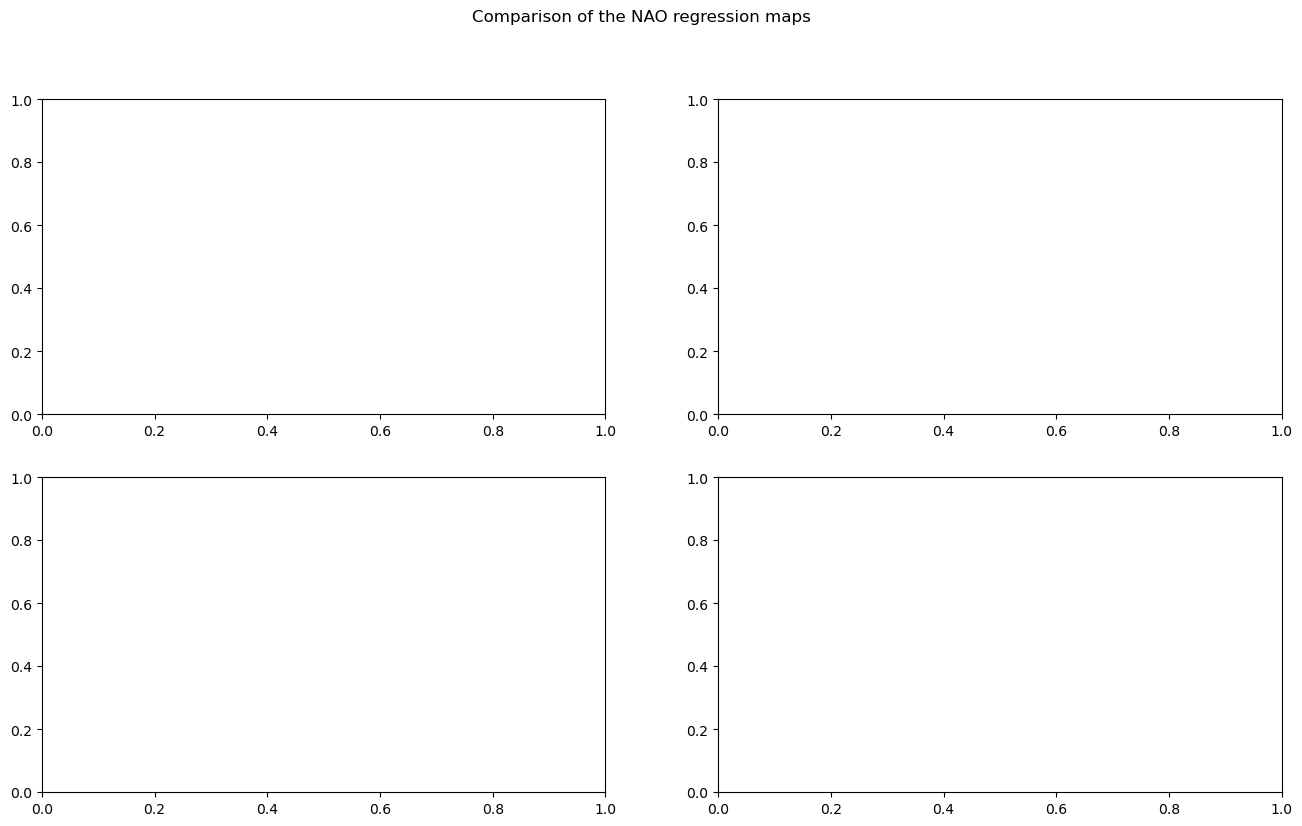

In [30]:
comparison_regression_plot(regs=[telec1.regression, telec2.regression, telec1.regression], models=[model1, model2, model1], exps=[exp1, exp2, exp1], telecname=telec1.telecname)

3


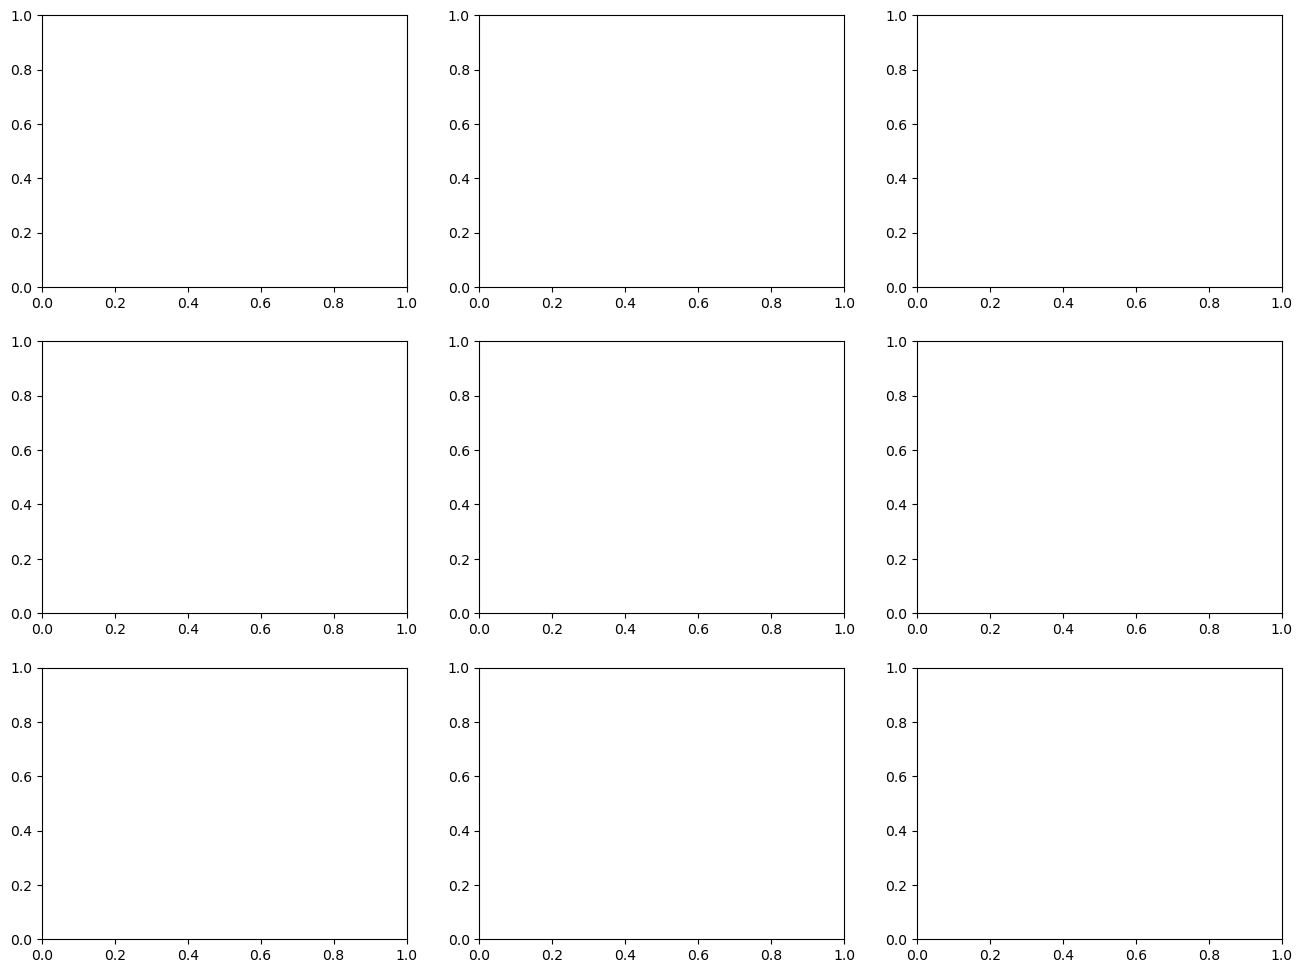

In [18]:
import numpy as np

sideSubPlot = int(np.ceil(np.sqrt(5)))
print(sideSubPlot)
fig, ax = plt.subplots(sideSubPlot, sideSubPlot, figsize = (16, 12))
        # fig, ax = plt.subplots(sideSubPlot, sideSubPlot, figsize = (16, 12))
        # for js, setup in enumerate(mySetups):
        #     label = " ".join([s for s in setup])
        #     for jr, region in enumerate(myRegions):

        #         extent = myExtents[js][jr]

        #         jx = jr // sideSubPlot
        #         jy = jr %  sideSubPlot


        #         ax[jx, jy].plot(extent.time, extent, label = label)

        #         ax[jx,jy].set_title("Sea ice extent: region " + region)

        #         ax[jx,jy].legend()
        #         ax[jx,jy].set_ylabel(extent.units)
        #         ax[jx,jy].grid()
        # fig.tight_layout()
        # for fmt in ["png", "pdf"]:
        #     fig.savefig("./figSIE." + fmt, dpi = 300)

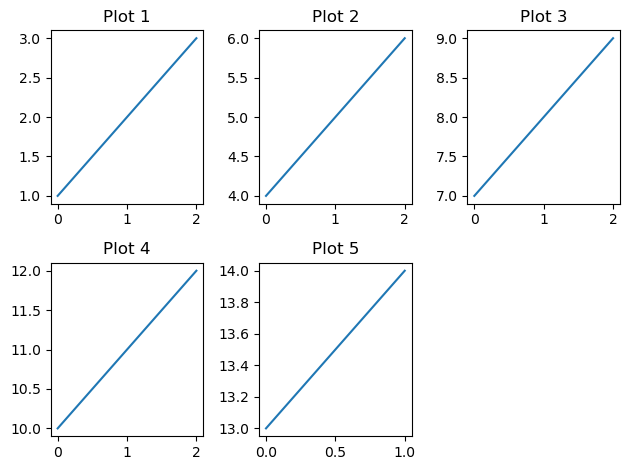

In [21]:
import matplotlib.pyplot as plt
import math

def plot_multiple(data, num_plots):
    num_cols = math.ceil(math.sqrt(num_plots))
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols)

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            ax.plot(data[i])
            ax.set_title(f'Plot {i+1}')
        else:
            # Hide unused subplots
            ax.axis('off')

    # Adjust spacing between subplots
    plt.tight_layout()

    plt.show()

# Example usage
data = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12], [13, 14]]
num_plots = len(data)

plot_multiple(data, num_plots)


In [ ]:
slurm.scancel()